# Import Libraries

In [2]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os

os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random

random.seed(SEED)

import numpy as np

np.random.seed(SEED)

import tensorflow as tf

tf.random.set_seed(SEED)

import math
import matplotlib.pyplot as plt

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup
from tensorflow.keras.callbacks import EarlyStopping

# Read Data

In [3]:
import pandas as pd

df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104089,8,2021,710 YISHUN AVENUE 5,Yishun,0.826153,14.410089,0.016807,0.000382,"4 ROOM, New Generation",61.750000,93.0,07 TO 09,390000.0
104090,8,2021,117 YISHUN RING ROAD,Yishun,1.045337,15.215236,0.016807,0.000382,"4 ROOM, Model A",60.916667,104.0,07 TO 09,380000.0
104091,8,2021,453 YISHUN STREET 41,Khatib,1.424543,13.350952,0.016807,0.000968,"4 ROOM, Model A",91.083333,93.0,04 TO 06,433000.0
104092,8,2021,505D YISHUN STREET 51,Khatib,1.259536,13.232993,0.016807,0.000968,"4 ROOM, Model A",93.666667,93.0,01 TO 03,460000.0


In [1]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop('resale_price')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(
        output_mode='binary')  # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

# Question 1

Real world datasets often contain a mix of numeric and categorical features – this dataset is one such example. Modelling such a mix of feature types with neural networks requires some modifications to the input layer. This tutorial from the Keras documentation guides you through the process of using the Functional API to do so.

In [5]:
class Question1():

    def __init__(self, train_ds, val_ds, epochs=100):
        self.epochs = epochs
        self.filepath = 'p2q1f.ckpt'
        self.history = None

        self.train_ds = train_ds
        self.val_ds = val_ds

    def prepare_model(self):
        # integer categorical feature input
        month = keras.Input(shape=(1,), name='month', dtype='int64')

        # string categorical features input
        storey_range = keras.Input(shape=(1,), name='storey_range', dtype='string')
        flat_model_type = keras.Input(shape=(1,), name='flat_model_type', dtype='string')

        # numerical features input
        floor_area_sqm = keras.Input(shape=(1,), name='floor_area_sqm')
        remaining_lease_years = keras.Input(shape=(1,), name='remaining_lease_years')
        degree_centrality = keras.Input(shape=(1,), name='degree_centrality')
        eigenvector_centrality = keras.Input(shape=(1,), name='eigenvector_centrality')
        dist_to_nearest_stn = keras.Input(shape=(1,), name='dist_to_nearest_stn')
        dist_to_dhoby = keras.Input(shape=(1,), name='dist_to_dhoby')

        self.all_inputs = [month,
                           storey_range,
                           flat_model_type,
                           floor_area_sqm,
                           remaining_lease_years,
                           degree_centrality,
                           eigenvector_centrality,
                           dist_to_nearest_stn,
                           dist_to_dhoby]

        # integer categorical feature encoded
        month_encoded = encode_categorical_feature(month, 'month', self.train_ds, False)

        # string categorical features encoded
        storey_range_encoded = encode_categorical_feature(storey_range, 'storey_range', self.train_ds, True)
        flat_model_type_encoded = encode_categorical_feature(flat_model_type, 'flat_model_type', self.train_ds, True)

        # numerical features encoded
        floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, 'floor_area_sqm', self.train_ds)
        remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, 'remaining_lease_years',
                                                                 self.train_ds)
        degree_centrality_encoded = encode_numerical_feature(degree_centrality, 'degree_centrality', self.train_ds)
        eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, 'eigenvector_centrality',
                                                                  self.train_ds)
        dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, 'dist_to_nearest_stn',
                                                               self.train_ds)
        dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, 'dist_to_dhoby', self.train_ds)

        self.all_features = tf.keras.layers.concatenate([month_encoded,
                                                         storey_range_encoded,
                                                         flat_model_type_encoded,
                                                         floor_area_sqm_encoded,
                                                         remaining_lease_years_encoded,
                                                         degree_centrality_encoded,
                                                         eigenvector_centrality_encoded,
                                                         dist_to_nearest_stn_encoded,
                                                         dist_to_dhoby_encoded])

    @staticmethod
    def r_square(y_true, y_pred):
        SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
        SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
        return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

    def create_model(self):
        # create the model
        x = tf.keras.layers.Dense(units=10, activation='relu')(self.all_features)
        output = tf.keras.layers.Dense(units=1, activation='linear')(x)
        self.model = tf.keras.Model(inputs=self.all_inputs, outputs=output)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
                           loss=tf.keras.losses.MeanSquaredError(),
                           metrics=[self.r_square])

    def summarize_model(self):
        # summarize the model
        print(self.model.summary())

    def train_model(self):
        # train the model
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.filepath,
                                                                       monitor='val_loss',
                                                                       verbose=1,
                                                                       save_best_only=True,
                                                                       save_weights_only=True,
                                                                       mode='min')
        self.history = self.model.fit(x=train_ds,
                                      batch_size=128,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[model_checkpoint_callback],
                                      validation_data=self.val_ds)

    def plot_model(self, variable='loss', epoch_start=1, epoch_end=None):
        # plot learning curves
        train_epochs = self.history.history[variable][epoch_start - 1:epoch_end]
        val_epochs = self.history.history['val_{}'.format(variable)][epoch_start - 1:epoch_end]
        number_epochs = len(self.history.history[variable][epoch_start - 1:epoch_end])

        plt.plot(range(epoch_start, epoch_start + number_epochs), train_epochs,
                 label='Model training {}'.format(variable))
        plt.plot(range(epoch_start, epoch_start + number_epochs), val_epochs, label='Model test {}'.format(variable))
        plt.title('Model {}'.format(variable))
        plt.ylabel('{}'.format(variable))
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

    def plot_rmse_model(self, epoch_start=1, epoch_end=None):
        # plot rmse curves
        train_epochs = list(map(lambda x: math.sqrt(x), self.history.history['loss'][epoch_start - 1:epoch_end]))
        val_epochs = list(map(lambda x: math.sqrt(x), self.history.history['val_loss'][epoch_start - 1:epoch_end]))
        number_epochs = len(self.history.history['loss'][epoch_start - 1:epoch_end])

        plt.plot(range(epoch_start, epoch_start + number_epochs), train_epochs, label='Model training rmse')
        plt.plot(range(epoch_start, epoch_start + number_epochs), val_epochs, label='Model test rmse')
        plt.title('Model rmse')
        plt.ylabel('rmse')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

    def get_lowest_test_error_model(self):
        # get lowest test error epoch and R2 value
        lowest_test_error, lowest_test_error_epoch = min(
            (value, index + 1) for (index, value) in enumerate(self.history.history['val_loss']))
        print('Lowest test error: {}'.format(lowest_test_error))
        print('Lowest test error epoch: {}'.format(lowest_test_error_epoch))
        print('Lowest test error epoch\'s R2 value: {}'.format(
            self.history.history['val_r_square'][lowest_test_error_epoch - 1]))

    def restore_best_model_and_predict(self):
        # restore weights to model from lowest test error epoch
        print('Before restore best model weights, model has test loss and test r_square as follows:')
        self.model.evaluate(self.val_ds)
        print('After restore best model weights, model has test loss and test r_square as follows:')
        self.model.load_weights(filepath=self.filepath)
        self.model.evaluate(self.val_ds)
        print('')
        target_values = list(self.val_ds.take(1).as_numpy_iterator())[0][1]
        predicted_values = self.model.predict(x=self.val_ds, steps=1)

        # plot targets and predictions
        plt.figure(1, figsize=(32, 4))
        plt.plot(target_values, 'b^', label='Model target values')
        plt.plot(predicted_values, 'ro', label='Model predicted values')
        plt.title('Best model target values and predicted values')
        plt.ylabel('resale price')
        plt.xlabel('ith test sample from batch 1')
        plt.legend(loc='best')
        plt.show()


a) Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets by using entries from year 2020 and before as training data (with the remaining data from year 2021 used as test data). Why is this done instead of random train/test splits?

In [6]:
#Split data
train_dataframe = df[df['year'] <= 2020].reset_index(drop=True)
val_dataframe = df[df['year'] == 2021].reset_index(drop=True)

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

b) Following this tutorial, design a 2-layer feedforward neural network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation function), and a linear output layer. One-hot encoding should be applied to categorical features and numeric features are standardised. After encoding / standardisation, the input features should be concatenated.

The input layer should use these features:
- Numeric features: dist_to_nearest_stn, dist_to_dhoby, degree_centrality, eigenvector_centrality, remaining_lease_years, floor_area_sqm

- Categorical features: month, flat_model_type, storey_range

Your architecture should resemble the figure shown on the next page.

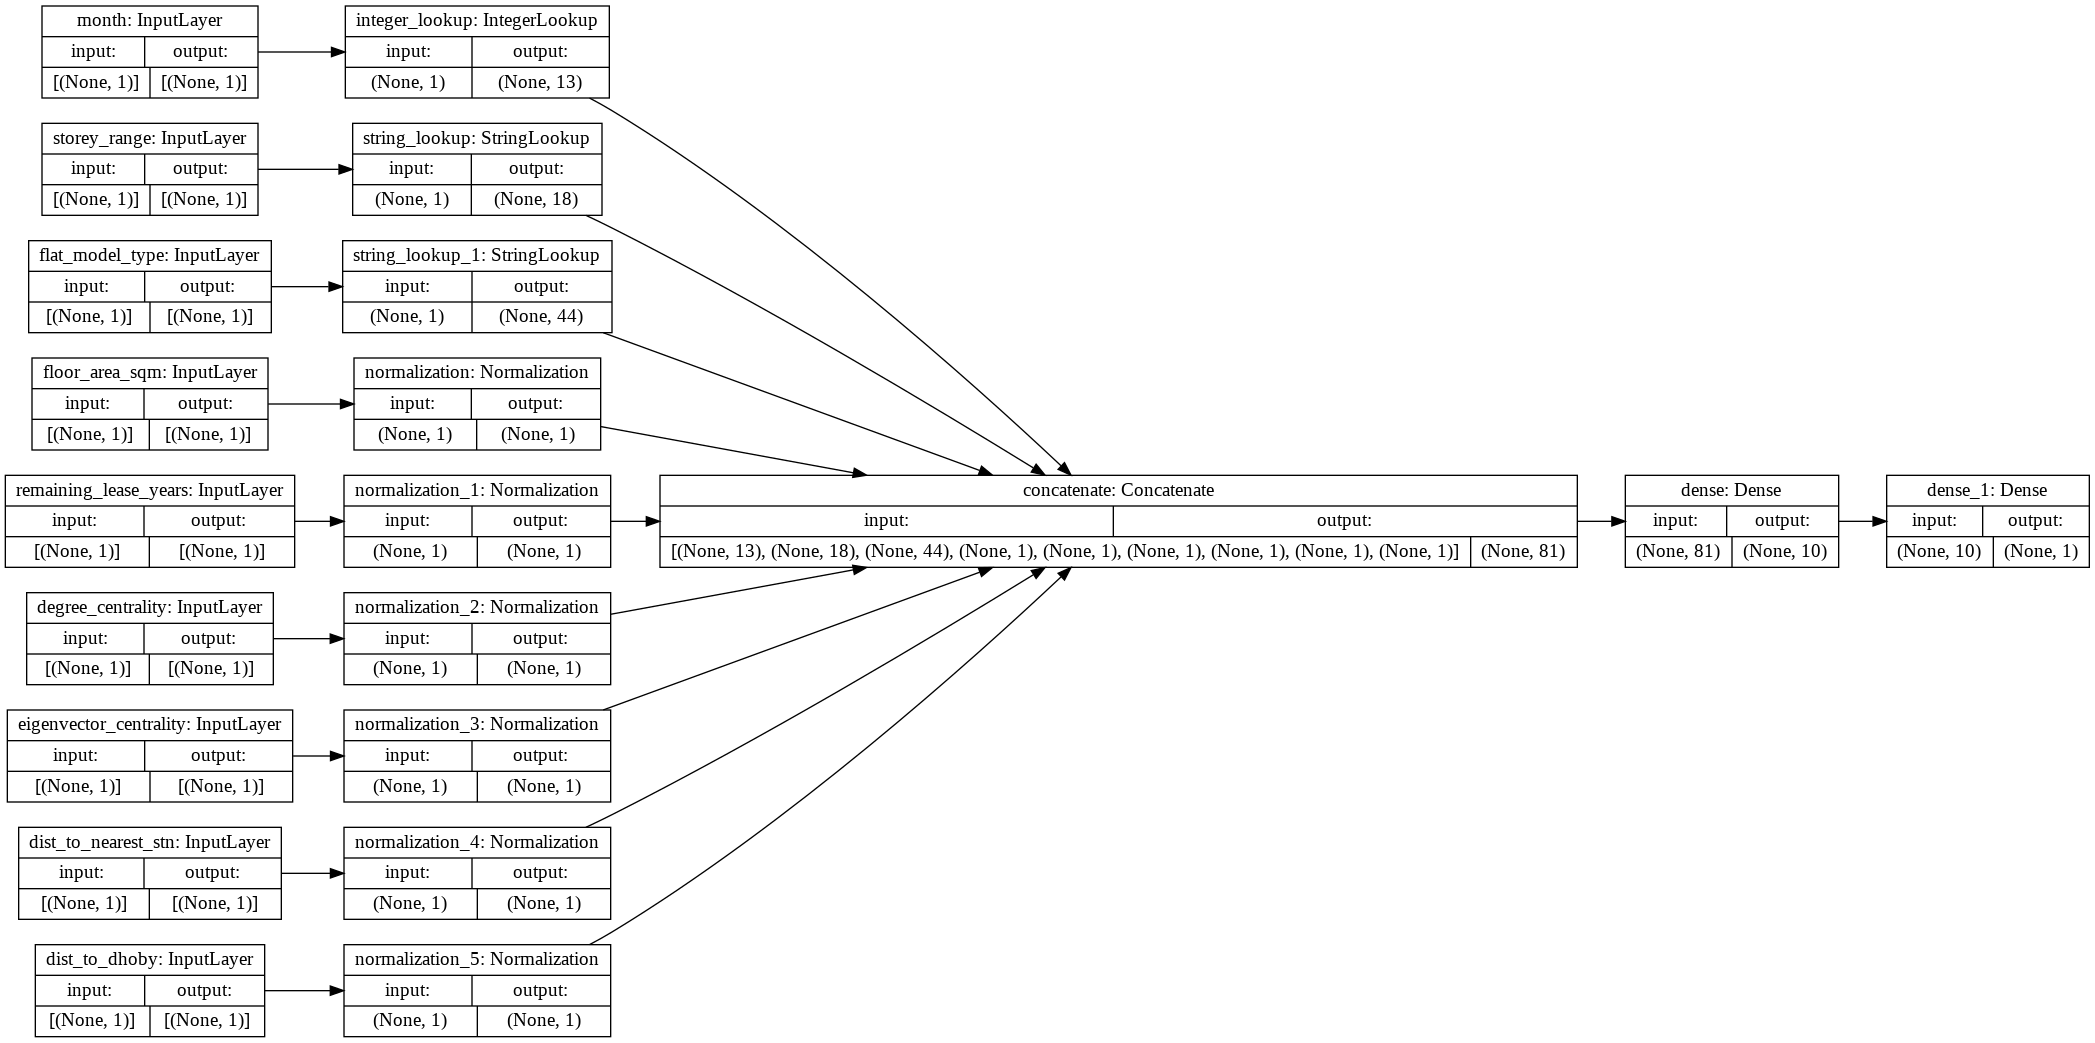

In [7]:
question1 = Question1(train_ds, val_ds)
question1.prepare_model()
question1.create_model()
keras.utils.plot_model(model=question1.model, to_file='p2q1b.png', show_shapes=True, rankdir="LR")

c) On the training data, train the model for 100 epochs using mini-batch gradient descent with batch size = 128, Use ‘adam’ optimiser with a learning rate of alpha = 0.05 and mean square error as cost function. (Tip: Use smaller epochs while you’re still debugging. On Google Colaboratory, 100 epochs take around 10 minutes even without GPU.)

In [8]:
question1.train_model()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_loss improved from inf to 170675159040.00000, saving model to p2q1f.ckpt

Epoch 00002: val_loss improved from 170675159040.00000 to 39814483968.00000, saving model to p2q1f.ckpt

Epoch 00003: val_loss improved from 39814483968.00000 to 11000308736.00000, saving model to p2q1f.ckpt

Epoch 00004: val_loss improved from 11000308736.00000 to 8578772480.00000, saving model to p2q1f.ckpt

Epoch 00005: val_loss improved from 8578772480.00000 to 7987134464.00000, saving model to p2q1f.ckpt

Epoch 00006: val_loss improved from 7987134464.00000 to 7682759168.00000, saving model to p2q1f.ckpt

Epoch 00007: val_loss improved from 7682759168.00000 to 7283898368.00000, saving model to p2q1f.ckpt

Epoch 00008: val_loss improved from 7283898368.00000 to 7108577792.00000, saving model to p2q1f.ckpt

Epoch 00009: val_loss improved from 7108577792.00000 to 6924158976.00000, saving model to p2q1f.ckpt

Epoch 00010: val_loss improved from 6924158976.00000 to 6620040704.00000, saving model

d) Plot the train and test root mean square errors (RMSE) against epochs (Tip: skip the first few epochs, else the plot gets dominated by them).

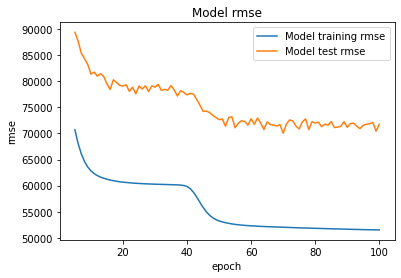

In [9]:
question1.plot_rmse_model(epoch_start=5)

e) State the epoch with the lowest test error. State the test R2 value at that epoch. (Hint: Check the output returned by model.fit(). Use a custom metric for computing R2.)

In [10]:
question1.get_lowest_test_error_model()

Lowest test error: 4905354240.0
Lowest test error epoch: 70
Lowest test error epoch's R2 value: 0.8073933720588684


f) Using the model from that best epoch, plot the predicted values and target values for a batch of 128 test samples. (Hint: Use a callback to restore the best model weights. Find out how to retrieve a batch from tf.BatchDataset. A scatter plot will suffice.)

Before restore best model weights, model has test loss and test r_square as follows:
131/131 [==============================] - 1s 5ms/step - loss: 5148116992.0000 - r_square: 0.7978
After restore best model weights, model has test loss and test r_square as follows:
131/131 [==============================] - 1s 5ms/step - loss: 4905354752.0000 - r_square: 0.8076



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


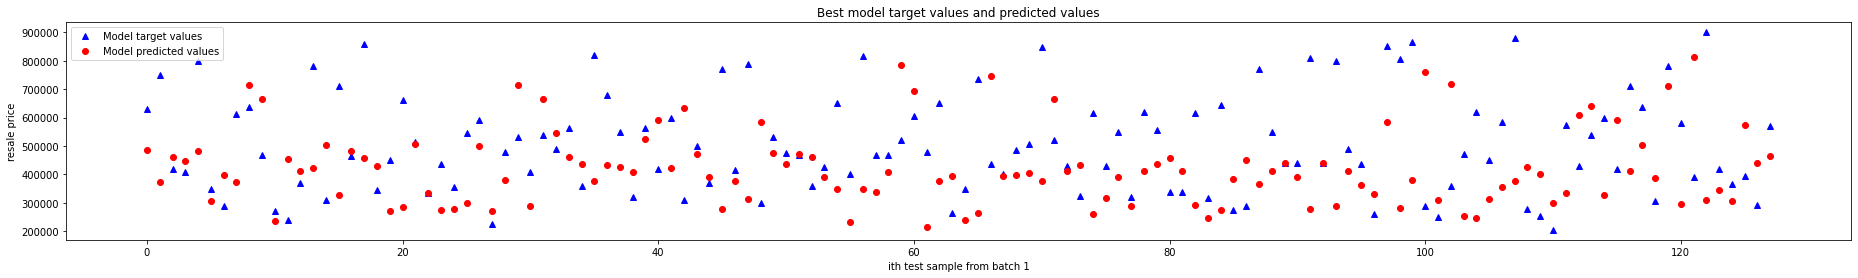

In [11]:
question1.restore_best_model_and_predict()  # test loss and test r_square after restore best model weights

# Question 2

Instead of using one-hot encoding, an alternative approach entails the use of embeddings to encode categorical variables. Such an approach utilises the ability of neural networks to learn richer representations of the data – an edge it has over traditional ML models.

In [12]:
class Question2():

    def __init__(self, train_ds, val_ds, epochs=100):
        self.epochs = epochs
        self.filepath = 'p2q2b.ckpt'
        self.history = None

        self.train_ds = train_ds
        self.val_ds = val_ds

    @staticmethod
    def modified_encode_categorical_feature(feature, name, dataset, is_string):
        lookup_class = StringLookup if is_string else IntegerLookup
        lookup = lookup_class(
            output_mode='int')
        feature_ds = dataset.map(lambda x, y: x[name])
        feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
        lookup.adapt(feature_ds)
        encoded_feature = lookup(feature)
        return encoded_feature

    def prepare_model(self):
        # integer categorical feature input
        month = keras.Input(shape=(1,), name='month', dtype='int64')

        # string categorical features input
        storey_range = keras.Input(shape=(1,), name='storey_range', dtype='string')
        flat_model_type = keras.Input(shape=(1,), name='flat_model_type', dtype='string')

        # numerical features input
        floor_area_sqm = keras.Input(shape=(1,), name='floor_area_sqm')
        remaining_lease_years = keras.Input(shape=(1,), name='remaining_lease_years')
        degree_centrality = keras.Input(shape=(1,), name='degree_centrality')
        eigenvector_centrality = keras.Input(shape=(1,), name='eigenvector_centrality')
        dist_to_nearest_stn = keras.Input(shape=(1,), name='dist_to_nearest_stn')
        dist_to_dhoby = keras.Input(shape=(1,), name='dist_to_dhoby')

        self.all_inputs = [month,
                           storey_range,
                           flat_model_type,
                           floor_area_sqm,
                           remaining_lease_years,
                           degree_centrality,
                           eigenvector_centrality,
                           dist_to_nearest_stn,
                           dist_to_dhoby]

        # integer categorical feature modified encoded
        month_modified_encoded = self.modified_encode_categorical_feature(month, 'month', self.train_ds, False)

        # string categorical features modified encoded
        storey_range_modified_encoded = self.modified_encode_categorical_feature(storey_range, 'storey_range',
                                                                                 self.train_ds, True)
        flat_model_type_modified_encoded = self.modified_encode_categorical_feature(flat_model_type, 'flat_model_type',
                                                                                    self.train_ds, True)

        # numerical features encoded
        floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, 'floor_area_sqm', self.train_ds)
        remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, 'remaining_lease_years',
                                                                 self.train_ds)
        degree_centrality_encoded = encode_numerical_feature(degree_centrality, 'degree_centrality', self.train_ds)
        eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, 'eigenvector_centrality',
                                                                  self.train_ds)
        dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, 'dist_to_nearest_stn',
                                                               self.train_ds)
        dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, 'dist_to_dhoby', self.train_ds)

        # integer categorical feature embedded and flattened
        month_embedding = tf.keras.layers.Embedding(input_dim=13, output_dim=(13 - 1) // 2)(month_modified_encoded)
        month_embedding_flattened = tf.keras.layers.Flatten()(month_embedding)

        # string categorical features embedded and flattened
        storey_range_embedding = tf.keras.layers.Embedding(input_dim=18, output_dim=(18 - 1) // 2)(
            storey_range_modified_encoded)
        storey_range_embedding_flattened = tf.keras.layers.Flatten()(storey_range_embedding)
        flat_model_type_embedding = tf.keras.layers.Embedding(input_dim=44, output_dim=(44 - 1) // 2)(
            flat_model_type_modified_encoded)
        flat_model_type_embedding_flattened = tf.keras.layers.Flatten()(flat_model_type_embedding)

        self.all_features = tf.keras.layers.concatenate([month_embedding_flattened,
                                                         storey_range_embedding_flattened,
                                                         flat_model_type_embedding_flattened,
                                                         floor_area_sqm_encoded,
                                                         remaining_lease_years_encoded,
                                                         degree_centrality_encoded,
                                                         eigenvector_centrality_encoded,
                                                         dist_to_nearest_stn_encoded,
                                                         dist_to_dhoby_encoded])

    @staticmethod
    def r_square(y_true, y_pred):
        SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
        SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
        return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

    def create_model(self):
        # create the model
        x = tf.keras.layers.Dense(units=10, activation='relu')(self.all_features)
        output = tf.keras.layers.Dense(units=1, activation='linear')(x)
        self.model = tf.keras.Model(inputs=self.all_inputs, outputs=output)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
                           loss=tf.keras.losses.MeanSquaredError(),
                           metrics=[self.r_square])

    def summarize_model(self):
        # summarize the model
        print(self.model.summary())

    def train_model(self):
        # train the model
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.filepath,
                                                                       monitor='val_loss',
                                                                       verbose=1,
                                                                       save_best_only=True,
                                                                       save_weights_only=True,
                                                                       mode='min')
        self.history = self.model.fit(x=train_ds,
                                      batch_size=128,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[model_checkpoint_callback],
                                      validation_data=self.val_ds)

    def plot_model(self, variable='loss', epoch_start=1, epoch_end=None):
        # plot learning curves
        train_epochs = self.history.history[variable][epoch_start - 1:epoch_end]
        val_epochs = self.history.history['val_{}'.format(variable)][epoch_start - 1:epoch_end]
        number_epochs = len(self.history.history[variable][epoch_start - 1:epoch_end])

        plt.plot(range(epoch_start, epoch_start + number_epochs), train_epochs,
                 label='Model training {}'.format(variable))
        plt.plot(range(epoch_start, epoch_start + number_epochs), val_epochs, label='Model test {}'.format(variable))
        plt.title('Model {}'.format(variable))
        plt.ylabel('{}'.format(variable))
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

    def plot_rmse_model(self, epoch_start=1, epoch_end=None):
        # plot rmse curves
        train_epochs = list(map(lambda x: math.sqrt(x), self.history.history['loss'][epoch_start - 1:epoch_end]))
        val_epochs = list(map(lambda x: math.sqrt(x), self.history.history['val_loss'][epoch_start - 1:epoch_end]))
        number_epochs = len(self.history.history['loss'][epoch_start - 1:epoch_end])

        plt.plot(range(epoch_start, epoch_start + number_epochs), train_epochs, label='Model training rmse')
        plt.plot(range(epoch_start, epoch_start + number_epochs), val_epochs, label='Model test rmse')
        plt.title('Model rmse')
        plt.ylabel('rmse')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

    def get_lowest_test_error_model(self):
        # get lowest test error epoch and R2 value
        lowest_test_error, lowest_test_error_epoch = min(
            (value, index + 1) for (index, value) in enumerate(self.history.history['val_loss']))
        print('Lowest test error: {}'.format(lowest_test_error))
        print('Lowest test error epoch: {}'.format(lowest_test_error_epoch))
        print('Lowest test error epoch\'s R2 value: {}'.format(
            self.history.history['val_r_square'][lowest_test_error_epoch - 1]))

    def restore_best_model_and_predict(self):
        # restore weights to model from lowest test error epoch
        print('Before restore best model weights, model has test loss and test r_square as follows:')
        self.model.evaluate(self.val_ds)
        print('After restore best model weights, model has test loss and test r_square as follows:')
        self.model.load_weights(filepath=self.filepath)
        self.model.evaluate(self.val_ds)
        print('')
        target_values = list(self.val_ds.take(1).as_numpy_iterator())[0][1]
        predicted_values = self.model.predict(x=self.val_ds, steps=1)

        # plot targets and predictions
        plt.figure(1, figsize=(32, 4))
        plt.plot(target_values, 'b^', label='Model target values')
        plt.plot(predicted_values, 'ro', label='Model predicted values')
        plt.title('Best model target values and predicted values')
        plt.ylabel('resale price')
        plt.xlabel('ith test sample from batch 1')
        plt.legend(loc='best')
        plt.show()


a) Add an Embedding layer with output_dim = floor(num_categories/2) after the one-hot embeddings for categorical variables. (Hint: Use the tf.keras.layers.Embedding() later. Read the documentation carefully to ensure that you define the correct function parameters.)

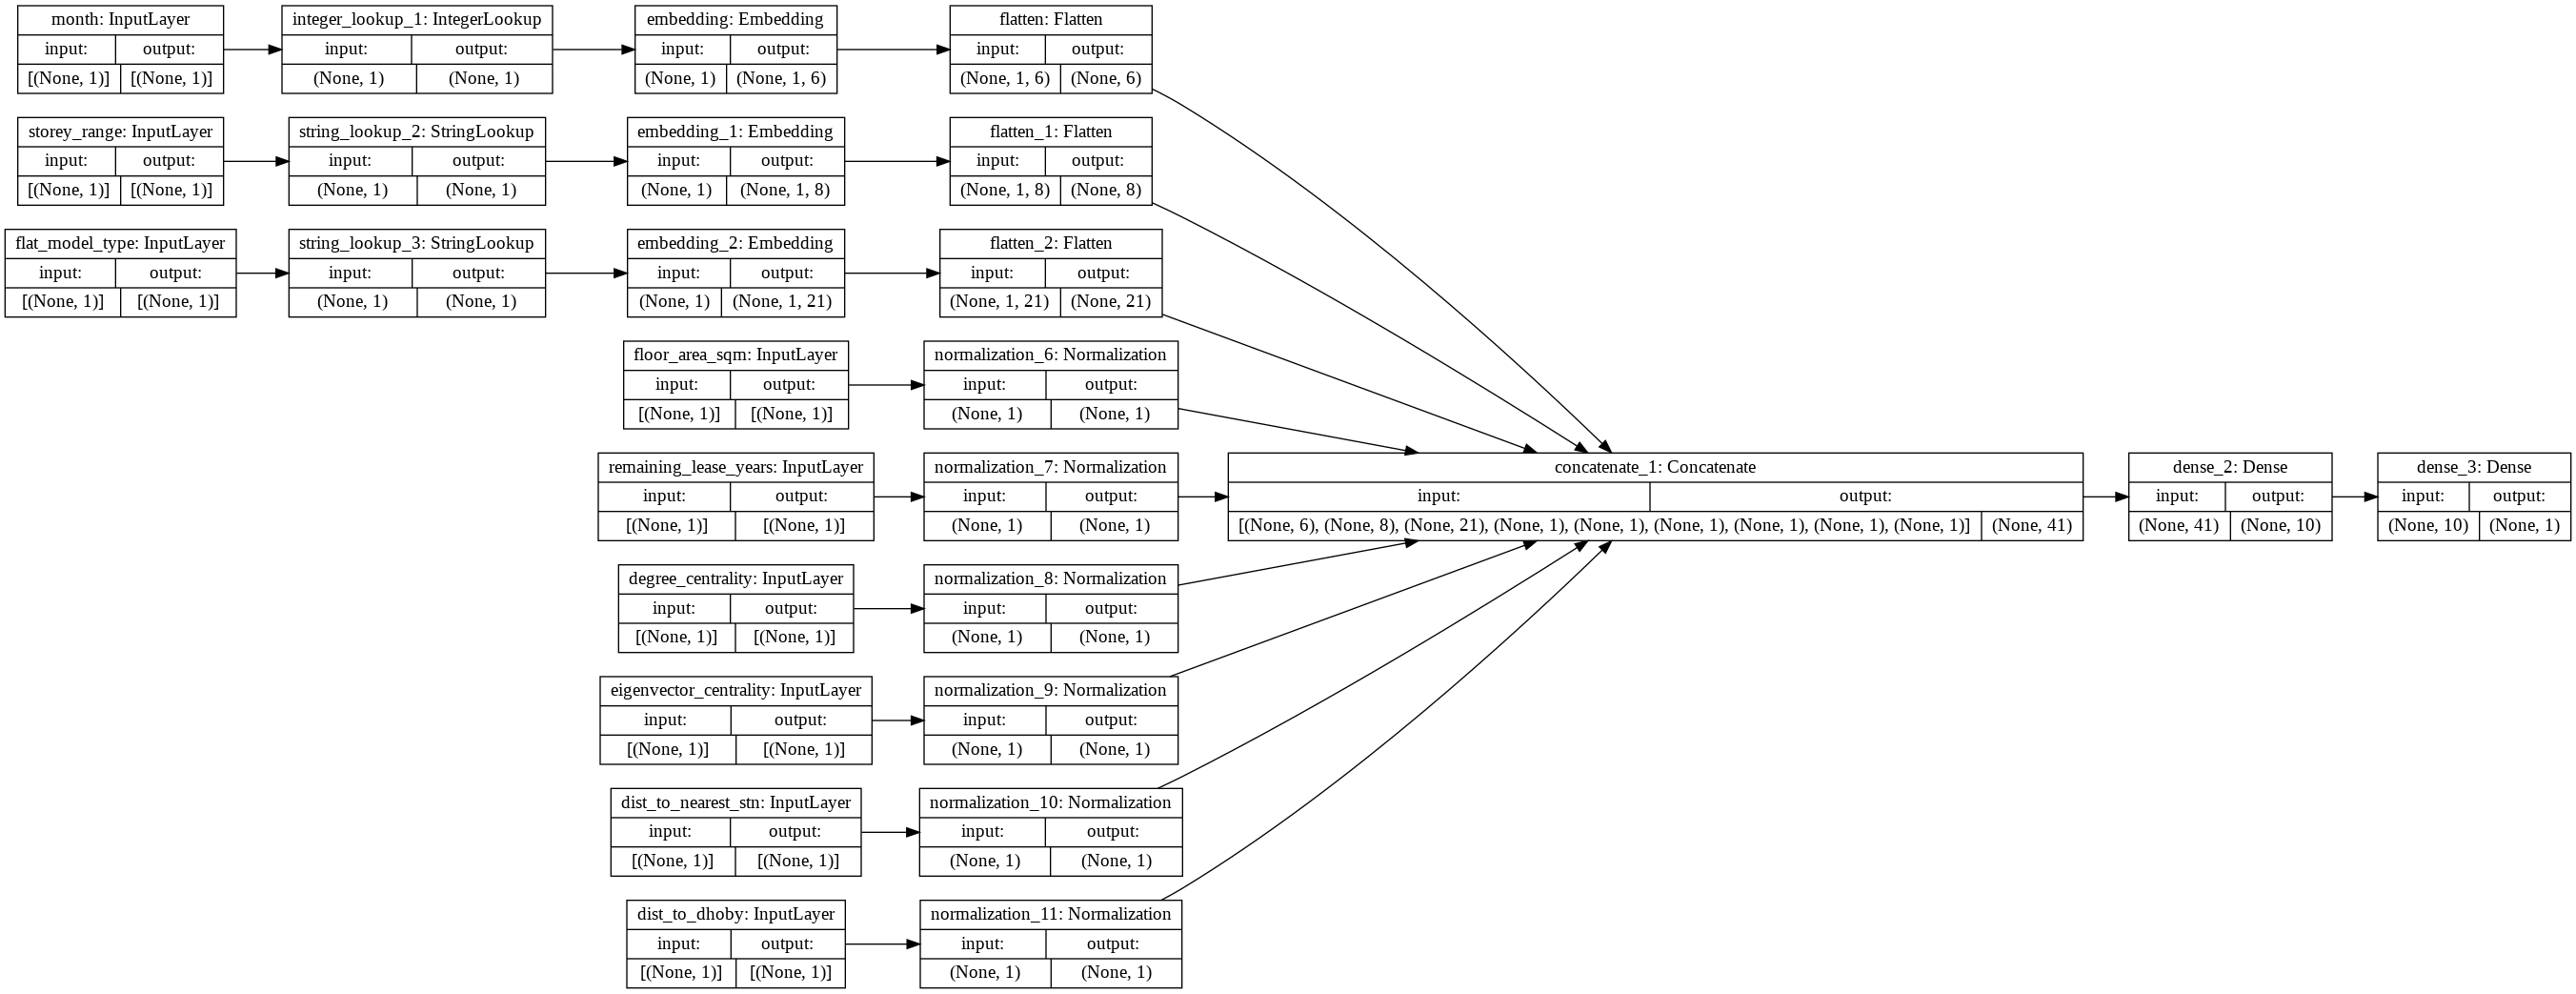

In [13]:
question2 = Question2(train_ds, val_ds)
question2.prepare_model()
question2.create_model()
keras.utils.plot_model(model=question2.model, to_file='p2q2a.png', show_shapes=True, rankdir="LR")

b) The Embedding layer produces a 2D output (3D, including batch), which cannot be concatenated with the other features. Look through the Keras layers API to determine which layer to add in, such that all the features can be concatenated. Train the model using the same configuration as Q1. (Tip: A full run takes ~15 mins, so reduce epochs when debugging your code but remember to switch it back to 100.)

In [14]:
question2.train_model()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_loss improved from inf to 11955050496.00000, saving model to p2q2b.ckpt

Epoch 00002: val_loss improved from 11955050496.00000 to 9837586432.00000, saving model to p2q2b.ckpt

Epoch 00003: val_loss improved from 9837586432.00000 to 8870615040.00000, saving model to p2q2b.ckpt

Epoch 00004: val_loss improved from 8870615040.00000 to 8416278528.00000, saving model to p2q2b.ckpt

Epoch 00005: val_loss improved from 8416278528.00000 to 7760881152.00000, saving model to p2q2b.ckpt

Epoch 00006: val_loss improved from 7760881152.00000 to 7299493376.00000, saving model to p2q2b.ckpt

Epoch 00007: val_loss improved from 7299493376.00000 to 7194804224.00000, saving model to p2q2b.ckpt

Epoch 00008: val_loss improved from 7194804224.00000 to 6534401024.00000, saving model to p2q2b.ckpt

Epoch 00009: val_loss did not improve from 6534401024.00000

Epoch 00010: val_loss did not improve from 6534401024.00000

Epoch 00011: val_loss improved from 6534401024.00000 to 6264822784.00000

c) Compare the current model performances in terms of both test RMSE and test R2 with the model from Q1 (at their own best epochs) and suggest a possible reason for the difference in performance. 

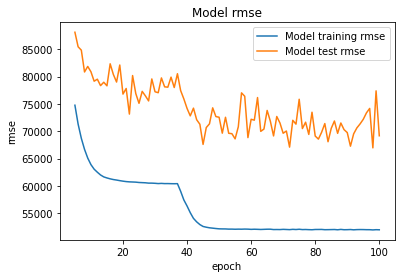

In [15]:
question2.plot_rmse_model(epoch_start=5)

In [16]:
question2.get_lowest_test_error_model()

Lowest test error: 4484649472.0
Lowest test error epoch: 98
Lowest test error epoch's R2 value: 0.8242164254188538


Before restore best model weights, model has test loss and test r_square as follows:
131/131 [==============================] - 1s 5ms/step - loss: 4785894912.0000 - r_square: 0.8140
After restore best model weights, model has test loss and test r_square as follows:
131/131 [==============================] - 1s 5ms/step - loss: 4484651008.0000 - r_square: 0.8244



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


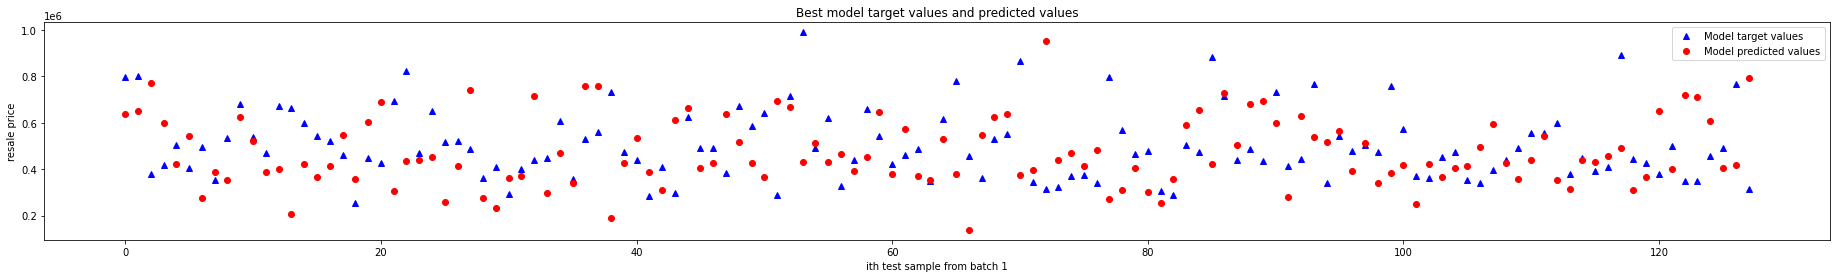

In [17]:
question2.restore_best_model_and_predict()  # test loss and test r_square after restore best model weights

# Question 3
Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. It can also shed some insights on how much each feature contributes to the prediction task.

In [18]:
class Question3():

    def __init__(self, train_ds, val_ds, epochs=100):
        self.epochs = epochs
        self.filepath = 'p2q3a.ckpt'
        self.history = None

        self.train_ds = train_ds
        self.val_ds = val_ds

    @staticmethod
    def modified_encode_categorical_feature(feature, name, dataset, is_string):
        lookup_class = StringLookup if is_string else IntegerLookup
        lookup = lookup_class(
            output_mode='int')
        feature_ds = dataset.map(lambda x, y: x[name])
        feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
        lookup.adapt(feature_ds)
        encoded_feature = lookup(feature)
        return encoded_feature

    def prepare_model(self):
        # integer categorical feature input
        month = keras.Input(shape=(1,), name='month', dtype='int64')

        # string categorical features input
        storey_range = keras.Input(shape=(1,), name='storey_range', dtype='string')
        flat_model_type = keras.Input(shape=(1,), name='flat_model_type', dtype='string')

        # numerical features input
        floor_area_sqm = keras.Input(shape=(1,), name='floor_area_sqm')
        remaining_lease_years = keras.Input(shape=(1,), name='remaining_lease_years')
        degree_centrality = keras.Input(shape=(1,), name='degree_centrality')
        eigenvector_centrality = keras.Input(shape=(1,), name='eigenvector_centrality')
        dist_to_nearest_stn = keras.Input(shape=(1,), name='dist_to_nearest_stn')
        dist_to_dhoby = keras.Input(shape=(1,), name='dist_to_dhoby')

        self.all_inputs = [month,
                           storey_range,
                           flat_model_type,
                           floor_area_sqm,
                           remaining_lease_years,
                           degree_centrality,
                           eigenvector_centrality,
                           dist_to_nearest_stn,
                           dist_to_dhoby]

        # integer categorical feature modified encoded
        month_modified_encoded = self.modified_encode_categorical_feature(month, 'month', self.train_ds, False)

        # string categorical features modified encoded
        storey_range_modified_encoded = self.modified_encode_categorical_feature(storey_range, 'storey_range',
                                                                                 self.train_ds, True)
        flat_model_type_modified_encoded = self.modified_encode_categorical_feature(flat_model_type, 'flat_model_type',
                                                                                    self.train_ds, True)

        # numerical features encoded
        floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, 'floor_area_sqm', self.train_ds)
        remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, 'remaining_lease_years',
                                                                 self.train_ds)
        degree_centrality_encoded = encode_numerical_feature(degree_centrality, 'degree_centrality', self.train_ds)
        eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, 'eigenvector_centrality',
                                                                  self.train_ds)
        dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, 'dist_to_nearest_stn',
                                                               self.train_ds)
        dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, 'dist_to_dhoby', self.train_ds)

        # integer categorical feature embedded and flattened
        month_embedding = tf.keras.layers.Embedding(input_dim=13, output_dim=(13 - 1) // 2)(month_modified_encoded)
        month_embedding_flattened = tf.keras.layers.Flatten()(month_embedding)

        # string categorical features embedded and flattened
        storey_range_embedding = tf.keras.layers.Embedding(input_dim=18, output_dim=(18 - 1) // 2)(
            storey_range_modified_encoded)
        storey_range_embedding_flattened = tf.keras.layers.Flatten()(storey_range_embedding)
        flat_model_type_embedding = tf.keras.layers.Embedding(input_dim=44, output_dim=(44 - 1) // 2)(
            flat_model_type_modified_encoded)
        flat_model_type_embedding_flattened = tf.keras.layers.Flatten()(flat_model_type_embedding)

        self.all_features = tf.keras.layers.concatenate([month_embedding_flattened,
                                                         storey_range_embedding_flattened,
                                                         flat_model_type_embedding_flattened,
                                                         floor_area_sqm_encoded,
                                                         remaining_lease_years_encoded,
                                                         degree_centrality_encoded,
                                                         eigenvector_centrality_encoded,
                                                         dist_to_nearest_stn_encoded,
                                                         dist_to_dhoby_encoded])

    @staticmethod
    def r_square(y_true, y_pred):
        SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
        SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
        return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

    def create_model(self):
        # create the model
        x = tf.keras.layers.Dense(units=10, activation='relu')(self.all_features)
        output = tf.keras.layers.Dense(units=1, activation='linear')(x)
        self.model = tf.keras.Model(inputs=self.all_inputs, outputs=output)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
                           loss=tf.keras.losses.MeanSquaredError(),
                           metrics=[self.r_square])

    def summarize_model(self):
        # summarize the model
        print(self.model.summary())

    def train_model(self):
        # train the model
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.filepath,
                                                                       monitor='val_loss',
                                                                       verbose=1,
                                                                       save_best_only=True,
                                                                       save_weights_only=True,
                                                                       mode='min')
        self.history = self.model.fit(x=train_ds,
                                      batch_size=128,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                                                 model_checkpoint_callback],
                                      validation_data=self.val_ds)

    def plot_model(self, variable='loss', epoch_start=1, epoch_end=None):
        # plot learning curves
        train_epochs = self.history.history[variable][epoch_start - 1:epoch_end]
        val_epochs = self.history.history['val_{}'.format(variable)][epoch_start - 1:epoch_end]
        number_epochs = len(self.history.history[variable][epoch_start - 1:epoch_end])

        plt.plot(range(epoch_start, epoch_start + number_epochs), train_epochs,
                 label='Model training {}'.format(variable))
        plt.plot(range(epoch_start, epoch_start + number_epochs), val_epochs, label='Model test {}'.format(variable))
        plt.title('Model {}'.format(variable))
        plt.ylabel('{}'.format(variable))
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

    def plot_rmse_model(self, epoch_start=1, epoch_end=None):
        # plot rmse curves
        train_epochs = list(map(lambda x: math.sqrt(x), self.history.history['loss'][epoch_start - 1:epoch_end]))
        val_epochs = list(map(lambda x: math.sqrt(x), self.history.history['val_loss'][epoch_start - 1:epoch_end]))
        number_epochs = len(self.history.history['loss'][epoch_start - 1:epoch_end])

        plt.plot(range(epoch_start, epoch_start + number_epochs), train_epochs, label='Model training rmse')
        plt.plot(range(epoch_start, epoch_start + number_epochs), val_epochs, label='Model test rmse')
        plt.title('Model rmse')
        plt.ylabel('rmse')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

    def get_lowest_test_error_model(self):
        # get lowest test error epoch and R2 value
        lowest_test_error, lowest_test_error_epoch = min(
            (value, index + 1) for (index, value) in enumerate(self.history.history['val_loss']))
        print('Lowest test error: {}'.format(lowest_test_error))
        print('Lowest test error epoch: {}'.format(lowest_test_error_epoch))
        print('Lowest test error epoch\'s R2 value: {}'.format(
            self.history.history['val_r_square'][lowest_test_error_epoch - 1]))

    def restore_best_model_and_predict(self):
        # restore weights to model from lowest test error epoch
        print('Before restore best model weights, model has test loss and test r_square as follows:')
        self.model.evaluate(self.val_ds)
        print('After restore best model weights, model has test loss and test r_square as follows:')
        self.model.load_weights(filepath=self.filepath)
        self.model.evaluate(self.val_ds)
        print('')
        target_values = list(self.val_ds.take(1).as_numpy_iterator())[0][1]
        predicted_values = self.model.predict(x=self.val_ds, steps=1)

        # plot targets and predictions
        plt.figure(1, figsize=(32, 4))
        plt.plot(target_values, 'b^', label='Model target values')
        plt.plot(predicted_values, 'ro', label='Model predicted values')
        plt.title('Best model target values and predicted values')
        plt.ylabel('resale price')
        plt.xlabel('ith test sample from batch 1')
        plt.legend(loc='best')
        plt.show()


a) Continue with the model architecture you have after Q2. Via a callback, introduce early stopping (based on val_loss, with patience of 10 epochs) to the model.

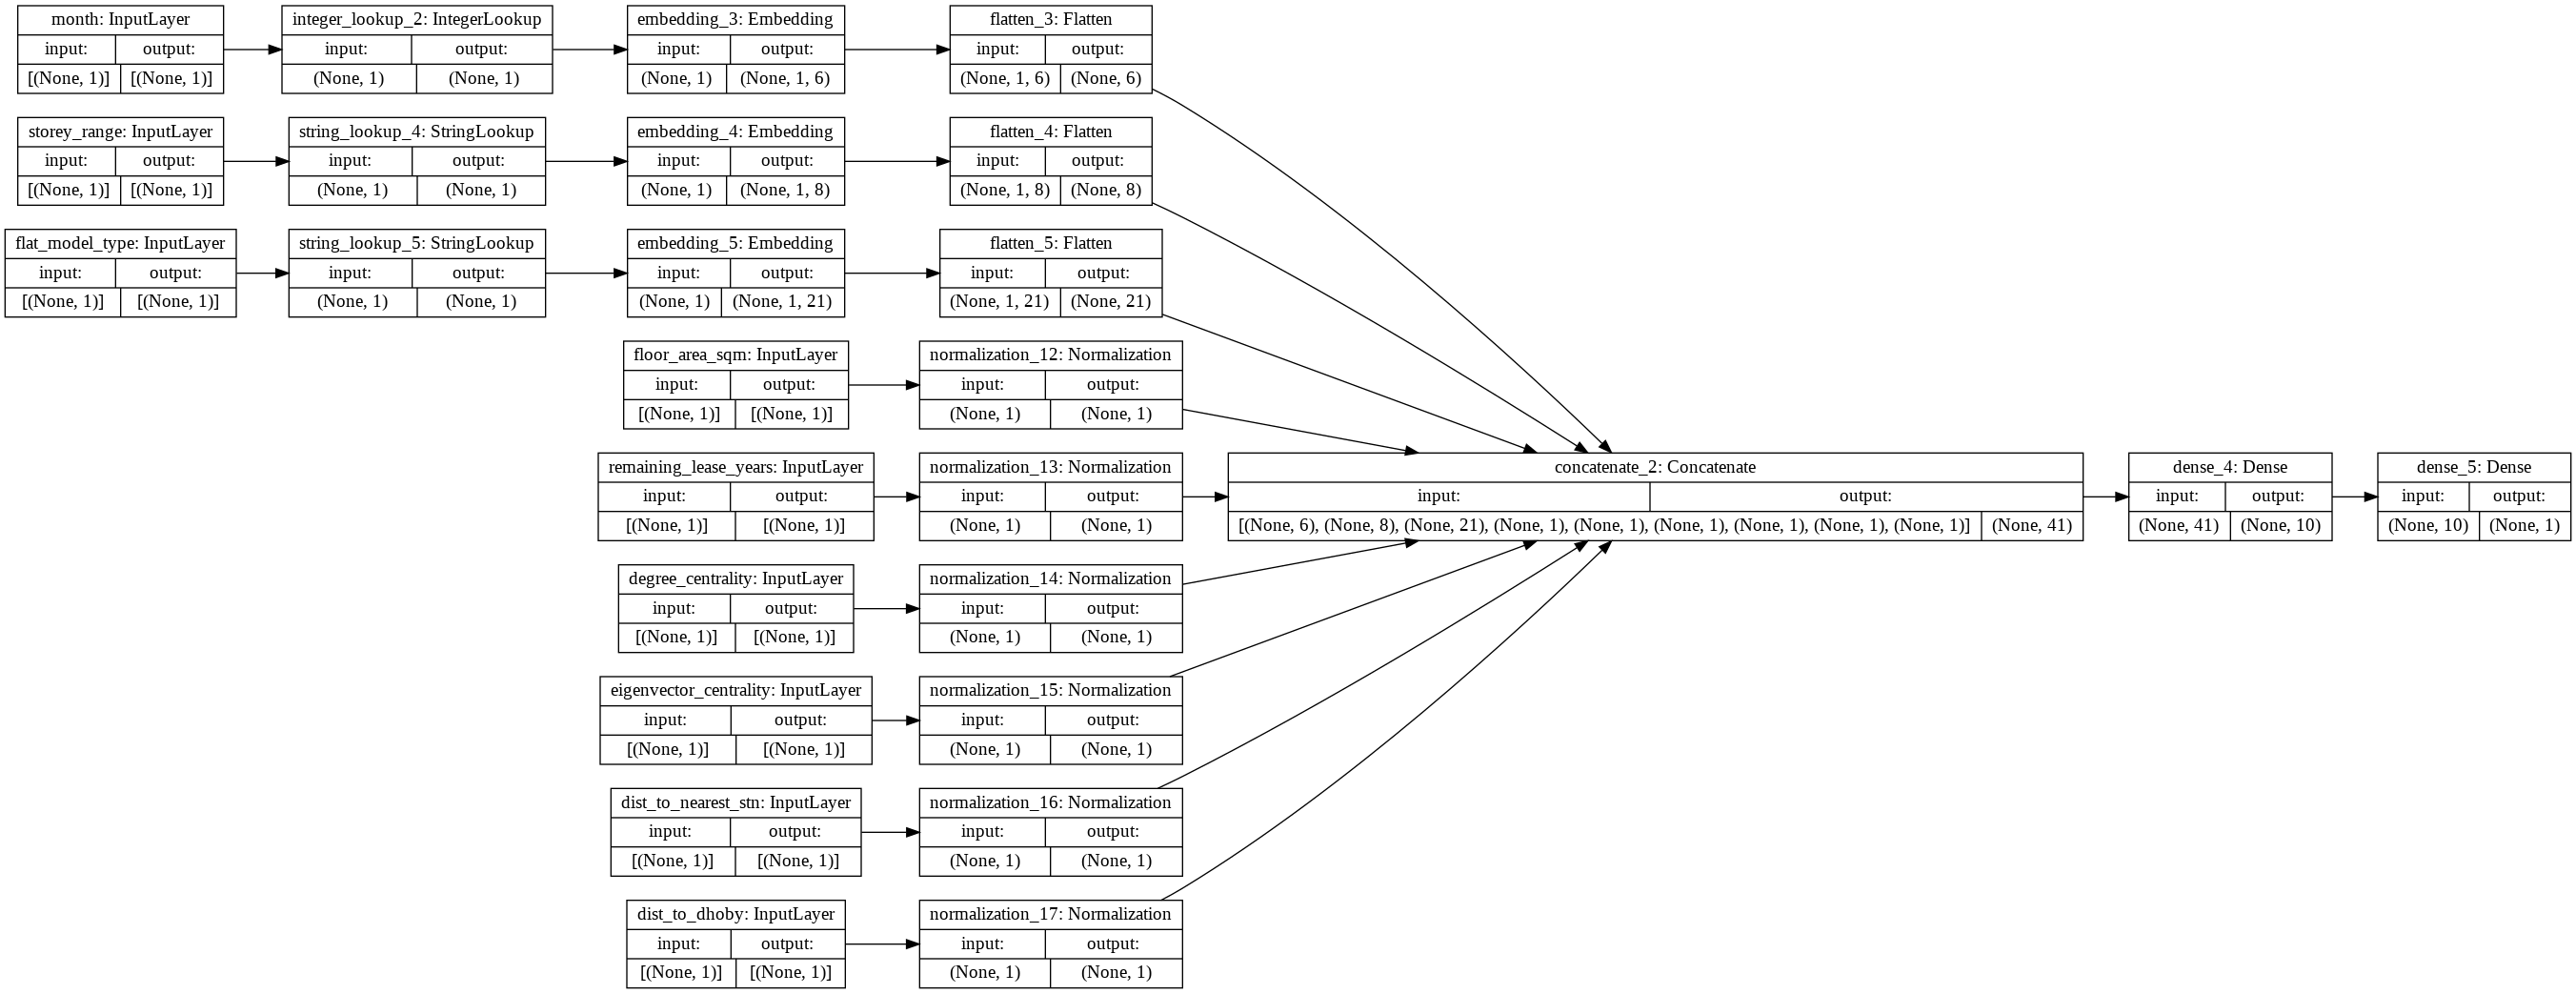

In [19]:
question3 = Question3(train_ds, val_ds)
question3.prepare_model()
question3.create_model()
keras.utils.plot_model(model=question3.model, to_file='p2q3a.png', show_shapes=True, rankdir="LR")

In [20]:
question3.train_model()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_loss improved from inf to 12566916096.00000, saving model to p2q3a.ckpt

Epoch 00002: val_loss improved from 12566916096.00000 to 10692359168.00000, saving model to p2q3a.ckpt

Epoch 00003: val_loss improved from 10692359168.00000 to 9718204416.00000, saving model to p2q3a.ckpt

Epoch 00004: val_loss improved from 9718204416.00000 to 8955179008.00000, saving model to p2q3a.ckpt

Epoch 00005: val_loss improved from 8955179008.00000 to 8463684608.00000, saving model to p2q3a.ckpt

Epoch 00006: val_loss improved from 8463684608.00000 to 7696327680.00000, saving model to p2q3a.ckpt

Epoch 00007: val_loss improved from 7696327680.00000 to 7676721664.00000, saving model to p2q3a.ckpt

Epoch 00008: val_loss improved from 7676721664.00000 to 7386259968.00000, saving model to p2q3a.ckpt

Epoch 00009: val_loss improved from 7386259968.00000 to 7007269376.00000, saving model to p2q3a.ckpt

Epoch 00010: val_loss improved from 7007269376.00000 to 6861689344.00000, saving model to 

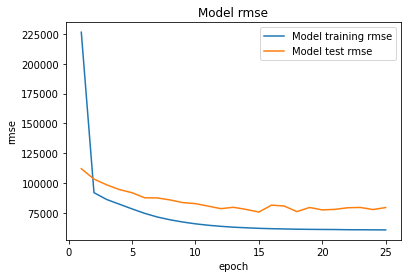

In [22]:
question3.plot_rmse_model()

b) Start by removing one input feature whose removal leads to the minimum drop (or maximum improvement) in performance. Repeat the procedure recursively on the reduced input set until the optimal number of input features is reached. Remember to remove features one at a time. Record the RMSE of each experiment neatly in a table (i.e., without feature 1, without feature 2, etc.). (Hint: Use a binary vector mask to keep track of the features. When you remove a feature, you do not have to repeatedly remove the initialisation of the input layers for each feature. Just choose which to include when you concatenate the features. Make sure to clear the session at every iteration of feature elimination. A full run take ~2hrs.)

In [23]:
class Question3RFEHelper():

    def __init__(self, train_ds, val_ds):
        self.train_ds = train_ds
        self.val_ds = val_ds
    
    @staticmethod
    def modified_encode_categorical_feature(feature, name, dataset, is_string):
        lookup_class = StringLookup if is_string else IntegerLookup
        lookup = lookup_class(
            output_mode='int')
        feature_ds = dataset.map(lambda x, y: x[name])
        feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
        lookup.adapt(feature_ds)
        encoded_feature = lookup(feature)
        return encoded_feature
    
    def prepare_rfe(self):
        # integer categorical feature input
        month = keras.Input(shape=(1,), name='month', dtype='int64')

        # string categorical features input
        storey_range = keras.Input(shape=(1,), name='storey_range', dtype='string')
        flat_model_type = keras.Input(shape=(1,), name='flat_model_type', dtype='string')

        # numerical features input
        floor_area_sqm = keras.Input(shape=(1,), name='floor_area_sqm')
        remaining_lease_years = keras.Input(shape=(1,), name='remaining_lease_years')
        degree_centrality = keras.Input(shape=(1,), name='degree_centrality')
        eigenvector_centrality = keras.Input(shape=(1,), name='eigenvector_centrality')
        dist_to_nearest_stn = keras.Input(shape=(1,), name='dist_to_nearest_stn')
        dist_to_dhoby = keras.Input(shape=(1,), name='dist_to_dhoby')

        self.all_inputs = [month,
                           storey_range,
                           flat_model_type,
                           floor_area_sqm,
                           remaining_lease_years,
                           degree_centrality,
                           eigenvector_centrality,
                           dist_to_nearest_stn,
                           dist_to_dhoby]

        # integer categorical feature modified encoded
        month_modified_encoded = self.modified_encode_categorical_feature(month, 'month', self.train_ds, False)

        # string categorical features modified encoded
        storey_range_modified_encoded = self.modified_encode_categorical_feature(storey_range, 'storey_range',
                                                                                 self.train_ds, True)
        flat_model_type_modified_encoded = self.modified_encode_categorical_feature(flat_model_type, 'flat_model_type',
                                                                                    self.train_ds, True)

        # numerical features encoded
        floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, 'floor_area_sqm', self.train_ds)
        remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, 'remaining_lease_years',
                                                                 self.train_ds)
        degree_centrality_encoded = encode_numerical_feature(degree_centrality, 'degree_centrality', self.train_ds)
        eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, 'eigenvector_centrality',
                                                                  self.train_ds)
        dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, 'dist_to_nearest_stn',
                                                               self.train_ds)
        dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, 'dist_to_dhoby', self.train_ds)

        # integer categorical feature embedded and flattened
        month_embedding = tf.keras.layers.Embedding(input_dim=13, output_dim=(13 - 1) // 2)(month_modified_encoded)
        month_embedding_flattened = tf.keras.layers.Flatten()(month_embedding)

        # string categorical features embedded and flattened
        storey_range_embedding = tf.keras.layers.Embedding(input_dim=18, output_dim=(18 - 1) // 2)(
            storey_range_modified_encoded)
        storey_range_embedding_flattened = tf.keras.layers.Flatten()(storey_range_embedding)
        flat_model_type_embedding = tf.keras.layers.Embedding(input_dim=44, output_dim=(44 - 1) // 2)(
            flat_model_type_modified_encoded)
        flat_model_type_embedding_flattened = tf.keras.layers.Flatten()(flat_model_type_embedding)

        self.all_features = [month_embedding_flattened,
                            storey_range_embedding_flattened,
                            flat_model_type_embedding_flattened,
                            floor_area_sqm_encoded,
                            remaining_lease_years_encoded,
                            degree_centrality_encoded,
                            eigenvector_centrality_encoded,
                            dist_to_nearest_stn_encoded,
                            dist_to_dhoby_encoded]
    
    def get_all_inputs(self):
        return self.all_inputs

    def get_all_features(self):
        return self.all_features

class Question3RFE():

    def __init__(self, train_ds, val_ds, all_inputs, all_features, features_mask, epochs=100):
        self.all_inputs = all_inputs
        self.all_features = all_features
        self.features_mask = features_mask
        self.epochs = epochs
        self.filepath = 'rfe/p2q3b-{}.ckpt'.format(features_mask)
        self.history = None

        self.train_ds = train_ds
        self.val_ds = val_ds

    def prepare_model(self):
        features_mask_list = list(map(int, list(self.features_mask)))
        self.rfe_inputs = []
        self.rfe_features = []

        for index, value in enumerate(features_mask_list):
            if value:
              self.rfe_inputs.append(self.all_inputs[index])
              self.rfe_features.append(self.all_features[index])
                
        self.rfe_features = tf.keras.layers.concatenate(self.rfe_features)

    @staticmethod
    def r_square(y_true, y_pred):
        SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
        SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
        return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

    def create_model(self):
        # create the model
        x = tf.keras.layers.Dense(units=10, activation='relu')(self.rfe_features)
        output = tf.keras.layers.Dense(units=1, activation='linear')(x)
        self.model = tf.keras.Model(inputs=self.rfe_inputs, outputs=output)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
                           loss=tf.keras.losses.MeanSquaredError(),
                           metrics=[self.r_square])

    def summarize_model(self):
        # summarize the model
        print(self.model.summary())

    def train_model(self):
        # train the model
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.filepath,
                                                                       monitor='val_loss',
                                                                       verbose=0,
                                                                       save_best_only=True,
                                                                       save_weights_only=True,
                                                                       mode='min')
        self.history = self.model.fit(x=train_ds,
                                      batch_size=128,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                                                 model_checkpoint_callback],
                                      validation_data=self.val_ds)
    
    def get_rfe_result(self):
        # get lowest test error epoch and R2 value
        lowest_test_error, lowest_test_error_epoch = min(
            (value, index + 1) for (index, value) in enumerate(self.history.history['val_loss']))
        lowest_test_error_epoch_R2_value = self.history.history['val_r_square'][lowest_test_error_epoch - 1]
        return (lowest_test_error, lowest_test_error_epoch_R2_value)


In [24]:
# num_features_key -> features_mask_key -> (test_error, R2)
rfe_results = {}
rfe_elimination_order = []

def question3_run_fre(train_ds, val_ds, all_inputs, all_features, features_mask, epochs=100):
  features_mask_list = list(map(int, list(features_mask)))
  
  if sum(features_mask_list) == 1:
      return
  
  if sum(features_mask_list) == 9:
      question3RFE = Question3RFE(train_ds, val_ds, all_inputs, all_features, features_mask, epochs)
      question3RFE.prepare_model()
      question3RFE.create_model()
      question3RFE.train_model()
      lowest_test_error, lowest_test_error_epoch_R2_value = question3RFE.get_rfe_result()
      rfe_results["num_features: 9"] = {}
      rfe_results["num_features: 9"]["features_mask_key: 111111111"] = (lowest_test_error, lowest_test_error_epoch_R2_value)

  num_features_key = "num_features: {}".format(sum(features_mask_list) - 1)
  if not rfe_results.get(num_features_key):
      rfe_results[num_features_key] = {}

  overall_lowest_test_error = None
  overall_lowest_test_error_features_mask = None

  for index, value in enumerate(features_mask_list):
    new_features_mask_list = [_ for _ in features_mask_list]
    if value:
      new_features_mask_list[index] = 0
      new_features_mask = "".join(list(map(str, new_features_mask_list)))
      features_mask_key = "features_mask_key: {}".format(new_features_mask)
      
      question3RFE = Question3RFE(train_ds, val_ds, all_inputs, all_features, new_features_mask, epochs)
      question3RFE.prepare_model()
      question3RFE.create_model()
      question3RFE.train_model()

      lowest_test_error, lowest_test_error_epoch_R2_value = question3RFE.get_rfe_result()
      rfe_results[num_features_key][features_mask_key] = (lowest_test_error, lowest_test_error_epoch_R2_value)

      if not overall_lowest_test_error or overall_lowest_test_error > lowest_test_error:
        overall_lowest_test_error = lowest_test_error
        overall_lowest_test_error_features_mask = new_features_mask

  rfe_elimination_order.append(overall_lowest_test_error_features_mask)

  question3_run_fre(train_ds, val_ds, all_inputs, all_features, overall_lowest_test_error_features_mask, epochs)

In [25]:
question3RFEHelper = Question3RFEHelper(train_ds, val_ds)
question3RFEHelper.prepare_rfe()
question3_run_fre(train_ds, val_ds, question3RFEHelper.get_all_inputs(), question3RFEHelper.get_all_features(),
                  features_mask="111111111")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address

c) Compare the performances of the model with all 9 input features (from Q2) and the best model arrived at by RFE, in terms of both RMSE and R2.

In [29]:
rfe_elimination_order

['111111101',
 '111111001',
 '011111001',
 '011110001',
 '011010001',
 '001010001',
 '001000001',
 '001000000']

In [30]:
rfe_results

{'num_features: 1': {'features_mask_key: 000000001': (27541968896.0,
   -0.06502615660429001),
  'features_mask_key: 001000000': (12734301184.0, 0.5079507231712341)},
 'num_features: 2': {'features_mask_key: 000010001': (20246769664.0,
   0.21862344443798065),
  'features_mask_key: 001000001': (7355895296.0, 0.7131523489952087),
  'features_mask_key: 001010000': (12112607232.0, 0.5330739617347717)},
 'num_features: 3': {'features_mask_key: 001010001': (5574002688.0,
   0.7833376526832581),
  'features_mask_key: 010010001': (19766734848.0, 0.23002399504184723),
  'features_mask_key: 011000001': (5951908352.0, 0.7675150632858276),
  'features_mask_key: 011010000': (10191127552.0, 0.6038256883621216)},
 'num_features: 4': {'features_mask_key: 001110001': (6618103808.0,
   0.7436879277229309),
  'features_mask_key: 010110001': (6273459712.0, 0.7552751302719116),
  'features_mask_key: 011010001': (6225031168.0, 0.7583208680152893),
  'features_mask_key: 011100001': (6579874816.0, 0.74397927

In [31]:
features_dictionary = {0: "month",
                       1: "storey_range",
                       2: "flat_model_type",
                       3: "floor_area_sqm",
                       4: "remaining_lease_years",
                       5: "degree_centrality",
                       6: "eigenvector_centrality",
                       7: "dist_to_nearest_stn",
                       8: "dist_to_dhoby"}

print("{} with test error {}".format('features_mask_key: 111111111', rfe_results['num_features: 9']['features_mask_key: 111111111']))

rfe_elimination_order_list = []

for features_mask in rfe_elimination_order:
    features_mask_list = list(map(int, list(features_mask)))
    num_features_key = "num_features: {}".format(sum(features_mask_list))
    features_mask_key = "features_mask_key: {}".format(features_mask)

    print("{} with test error {}".format(features_mask_key, rfe_results[num_features_key][features_mask_key]))

    for index, val in enumerate(features_mask_list):
        if not val and features_dictionary[index] not in rfe_elimination_order_list:
            rfe_elimination_order_list.append(features_dictionary[index])

print()
print(rfe_elimination_order_list)

features_mask_key: 111111111 with test error (5717853184.0, 0.777887225151062)
features_mask_key: 111111101 with test error (4377034752.0, 0.8280778527259827)
features_mask_key: 111111001 with test error (5687175168.0, 0.7782233953475952)
features_mask_key: 011111001 with test error (5718942208.0, 0.776461660861969)
features_mask_key: 011110001 with test error (5348214272.0, 0.7914275527000427)
features_mask_key: 011010001 with test error (6225031168.0, 0.7583208680152893)
features_mask_key: 001010001 with test error (5574002688.0, 0.7833376526832581)
features_mask_key: 001000001 with test error (7355895296.0, 0.7131523489952087)
features_mask_key: 001000000 with test error (12734301184.0, 0.5079507231712341)

['dist_to_nearest_stn', 'eigenvector_centrality', 'month', 'degree_centrality', 'floor_area_sqm', 'storey_range', 'remaining_lease_years', 'dist_to_dhoby']


d) By examining the changes in model performance whenever a feature is removed, evaluate the usefulness of each feature for the task of HDB resale price prediction.